# Assignment 4
### Do three of four.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ds_minnesota = pd.read_csv('mn_police_use_of_force.csv')
ds_tuna = pd.read_csv('tuna.csv')
ds_nhanes = pd.read_csv('nhanes_data_17_18.csv')

/var/folders/dv/rwkhhnhs4c9frqn6rc7njm6h0000gn/T/ipykernel_92697/3506253497.py:8: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  ds_nhanes = pd.read_csv('nhanes_data_17_18.csv')


### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [2]:
ds_nhanes.head()


,SEQN,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
0,93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
3,93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
4,93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
import matplotlib.pyplot as plt

PREFERRED_ORDER = ["BMXBMI", "RIDAGEYR", "BMXWT", "BMXHT", "BPXSY1", "BPXDI1"]  # edit as you like

def choose_numeric_var(dataframe, preferred=PREFERRED_ORDER):
    # Try preferred list first
    for col in preferred:
        if col in dataframe.columns and pd.api.types.is_numeric_dtype(dataframe[col]):
            # Avoid obvious IDs if possible (SEQN)
            if col.lower() not in ["seqn", "id"]:
                return col
    # Else pick first numeric column that doesn't look like an ID
    numeric_cols = [c for c in dataframe.select_dtypes(include="number").columns]
    for c in numeric_cols:
        if not any(tok in c.lower() for tok in ["seqn", "id"]):
            return c
    # Fallback: any numeric column
    if numeric_cols:
        return numeric_cols[0]
    raise ValueError("No numeric columns found to bootstrap.")

VAR = choose_numeric_var(ds_nhanes)
x = ds_nhanes[VAR].dropna().astype(float)

# 3 Define statistics
def stat_mean(s: pd.Series) -> float:
    return float(np.mean(s))

def stat_median(s: pd.Series) -> float:
    return float(np.median(s))

def stat_iqr(s: pd.Series) -> float:
    q1, q3 = np.quantile(s, [0.25, 0.75])
    return float(q3 - q1)

# 4 simulate() from class
def simulate(var: str, data: pd.DataFrame, fcn, S: int = 2000, plot: bool = False) -> np.ndarray:
    """
    Bootstrap resampling:
      - Draw S bootstrap samples (with replacement) from data[var]
      - Compute fcn on each sample
      - Return the array of estimates
    """
    x = data[var].dropna().astype(float)
    estimates = np.array([fcn(x.sample(frac=1.0, replace=True)) for _ in range(S)])

    if plot:
        # Sampling distribution histogram
        plt.figure(figsize=(8,4))
        plt.hist(estimates, bins=30, density=True)
        plt.axvline(x=fcn(x), linestyle='--')
        plt.title(f"Bootstrap Sampling Distribution of {fcn.__name__} for {var}")
        plt.xlabel("Estimate"); plt.ylabel("Density")
        plt.show()

        # ECDF
        xs = np.sort(estimates)
        ys = np.arange(1, len(xs)+1)/len(xs)
        plt.figure(figsize=(8,4))
        plt.plot(xs, ys)
        plt.axvline(x=fcn(x), linestyle='--')
        plt.title(f"ECDF of Bootstrap Estimates ({fcn.__name__})")
        plt.xlabel("Estimate"); plt.ylabel("ECDF")
        plt.show()

    return estimates

# 5 interval(L, H, estimates)
def interval(L: float, H: float, estimates: np.ndarray) -> tuple[float, float]:
    """
    Percentile interval: returns the L and H quantiles of the bootstrap estimates.
    Example: L=0.05, H=0.95 -> 90% CI
    """
    if not (0.0 <= L < H <= 1.0):
        raise ValueError("Require 0 <= L < H <= 1")
    lo, hi = np.quantile(estimates, [L, H])
    return float(lo), float(hi)

# 6 Run the bootstrap

S = 50000            # number of bootstrap resamples
L, H = 0.05, 0.95   # 90% percentile CI

est_mean  = simulate(VAR, ds_nhanes, stat_mean,   S=S, plot=False)
est_median= simulate(VAR, ds_nhanes, stat_median, S=S, plot=False)
est_iqr   = simulate(VAR, ds_nhanes, stat_iqr,    S=S, plot=False)

ci_mean   = interval(L, H, est_mean)
ci_median = interval(L, H, est_median)
ci_iqr    = interval(L, H, est_iqr)

point_mean   = stat_mean(x)
point_median = stat_median(x)
point_iqr    = stat_iqr(x)

summary = pd.DataFrame({
    "Variable": [VAR, VAR, VAR],
    "Statistic": ["Mean", "Median", "IQR"],
    "Point Estimate": [point_mean, point_median, point_iqr],
    f"{int((H-L)*100)}% CI Lower ({L})": [ci_mean[0], ci_median[0], ci_iqr[0]],
    f"{int((H-L)*100)}% CI Upper ({H})": [ci_mean[1], ci_median[1], ci_iqr[1]],
    "Bootstrap Samples (S)": [S, S, S],
    "Non-missing n": [len(x), len(x), len(x)]
})

print(f"Chosen variable: {VAR!r} (non-missing n = {len(x)})\n")
print(summary.to_string(index=False))


Chosen variable: 'EverBreastfedOrFedBreastmilk' (non-missing n = 1069)

                    Variable Statistic  Point Estimate  89% CI Lower (0.05)  89% CI Upper (0.95)  Bootstrap Samples (S)  Non-missing n
EverBreastfedOrFedBreastmilk      Mean        0.806361             0.786717             0.826006                  50000           1069
EverBreastfedOrFedBreastmilk    Median        1.000000             1.000000             1.000000                  50000           1069
EverBreastfedOrFedBreastmilk       IQR        0.000000             0.000000             0.000000                  50000           1069


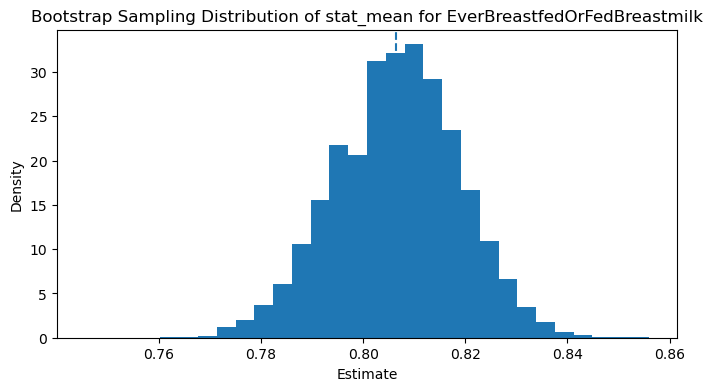

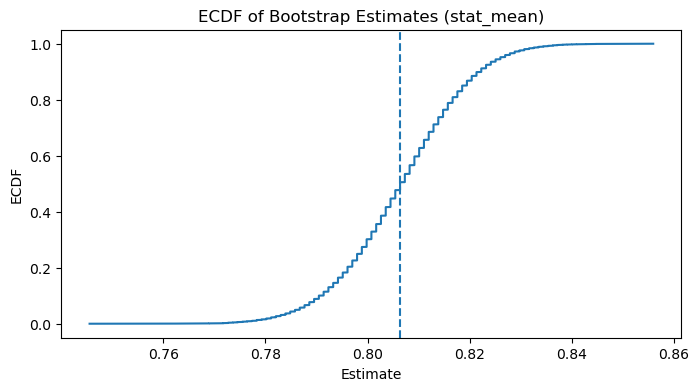

Variable: 'EverBreastfedOrFedBreastmilk'  (non-missing n = 1069)
Point estimate (mean): 0.8064
89% percentile interval: (0.7867, 0.8260)


In [4]:
S_demo = 20000
try:
    VAR
except NameError:
    VAR = choose_numeric_var(ds_nhanes)

est_mean_demo = simulate(VAR, ds_nhanes, stat_mean, S=S_demo, plot=True)

L, H = 0.05, 0.95
ci_low, ci_high = interval(L, H, est_mean_demo)
print(f'Variable: {VAR!r}  (non-missing n = {len(ds_nhanes[VAR].dropna())})')
print(f'Point estimate (mean): {stat_mean(ds_nhanes[VAR].dropna()):.4f}')
print(f'{int((H-L)*100)}% percentile interval: ({ci_low:.4f}, {ci_high:.4f})')

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

Goal of the Study: The study wants to find out if patients with serious kidney disease and
blocked heart arteries would live longer or avoid heart attacks if doctors treated them
right away with an invasive strategy (like stents or bypass surgery) or compared to a
conservative strategy (just medicines at first, and only doing procedures if symptoms
got worse). So in sum, the study wants to Compare invasive treatment vs. medicine only
treatment to see which helps patients survive longer and have fewer heart attacks.

Study Plan Design The researchers had two different ways to treat people Invasive
strategy: go inside the body to fix the blocked heart arteries with surgery or stents.
Conservative strategy: give medicines first and only do surgery if it became absolutely
necessary. To help control the experiment, they didn’t let patients or doctors pick
whichever one they liked. Instead, they randomly assigned each patient to one of the
two groups by chance, kind of like flipping a coin.

If people got to choose their own treatment, the results might be unfair — for example,
sicker patients might choose surgery more often, which would make surgery look worse
even if it wasn’t. By assigning people randomly, both groups end up being similar (same
mix of external factors), so any difference in outcomes can be blamed on the treatment
itself, not on the people being different at the start. The trial used intention-to-treat
design, meaning patients were analyzed in the group they were originally assigned to,
even if they later switched treatments. This avoids bias from crossover.

Contingency Table: 

Table 1 is like two big buckets of patients:
Bucket A = people who got the invasive treatment. Bucket B = people who got the
medicine first treatment.
Then inside each bucket, the researchers counted:
How many people had something bad happen (died or had a heart attack). How many
people did not have something bad happen.
From this table, we can calculate event rates (events ÷ total in group), survival rates (1 −
event rate), and then compare the two groups. This table is the basis for statistical tests
to see if the two groups are significantly different.

Survival Rates

At both time points, the invasive strategy group had a slightly higher survival rate than
the conservative group, but the difference was very small (about 1–2% at 2 years, almost
0% at 3 years). That tiny difference is not enough to prove the invasive strategy clearly
helped patients live longer. 

Last Part: As a result, looking at the bootstrapping results below for both groups, as well as the differences, this health intervention is likely not statistically significant despite the fact that the invasive group had a slightly different rate than the conservative group. The differences show that given an interval which likely crosses the 0 intercept, we cannot determine anything significant from these results right now. 

In [5]:
invasiveEvents = 123
invasiveNoEvents = 388 - 123  
conservativeEvents = 129
conservativeNoEvents = 389 - 129  

data = pd.DataFrame({
    'Arm': ['Invasive'] * 388 + ['Conservative'] * 389,
    'Event': [1] * invasiveEvents + [0] * invasiveNoEvents +
             [1] * conservativeEvents + [0] * conservativeNoEvents
})

print(pd.crosstab(data['Arm'], data['Event']))

Event           0    1
Arm                   
Conservative  260  129
Invasive      265  123


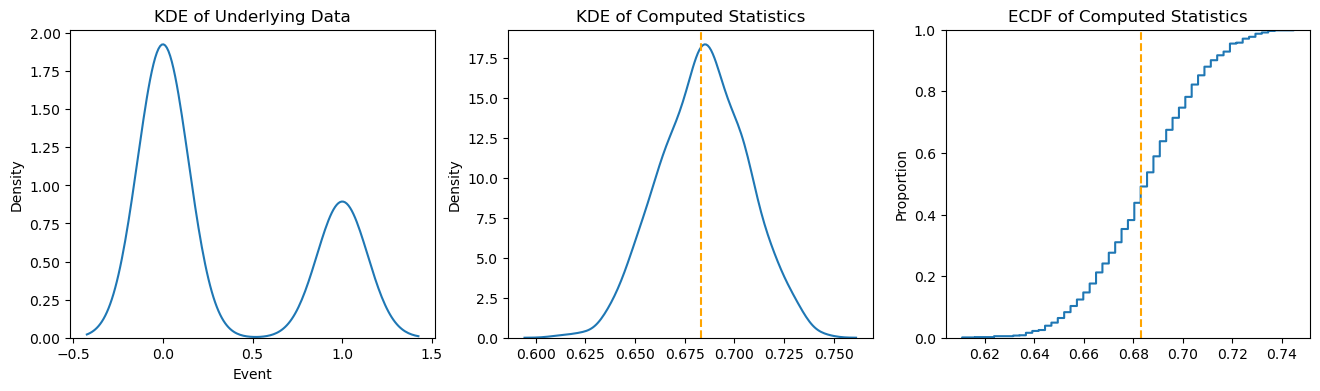

Variance of estimates is: 0.0004764600316186626


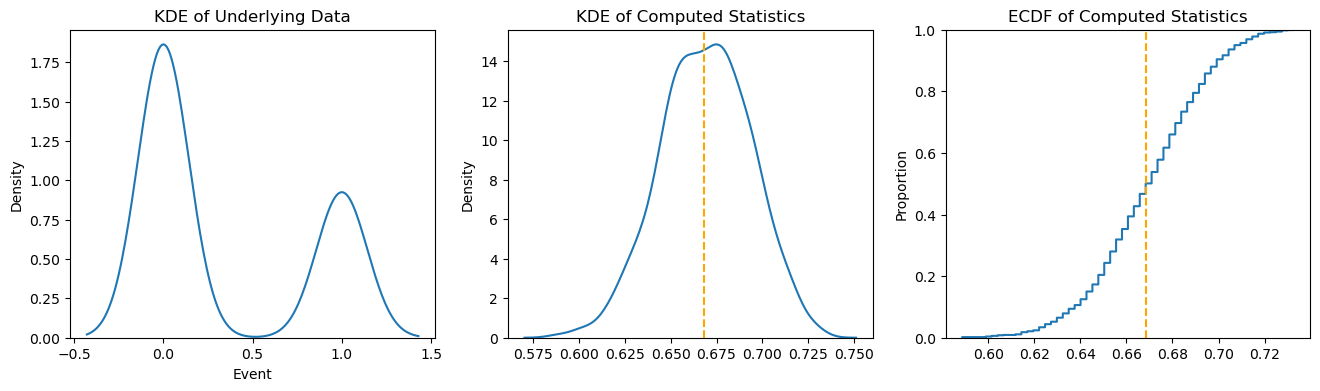

Variance of estimates is: 0.0005981422538841272


In [6]:
def stat(x):
    return 1 - np.mean(x) # proportion without event

def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S):
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates

invasive = data[data['Arm'] == 'Invasive']
conservative = data[data['Arm'] == 'Conservative']

invasive_boot = simulate('Event', invasive, stat)
conservative_boot = simulate('Event', conservative, stat)

/var/folders/dv/rwkhhnhs4c9frqn6rc7njm6h0000gn/T/ipykernel_92697/4201493161.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


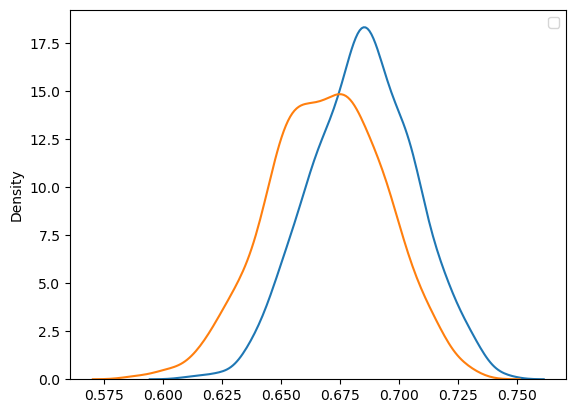

/var/folders/dv/rwkhhnhs4c9frqn6rc7njm6h0000gn/T/ipykernel_92697/4201493161.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


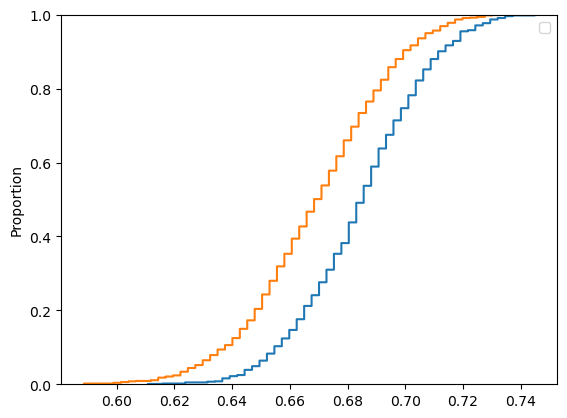

In [7]:
#invasive.plot.kde()
#conservative.plot.kde()

sns.kdeplot(invasive_boot)
sns.kdeplot(conservative_boot)
plt.legend()
plt.show()

sns.ecdfplot(invasive_boot)
sns.ecdfplot(conservative_boot)
plt.legend()
plt.show()

<Axes: ylabel='Density'>

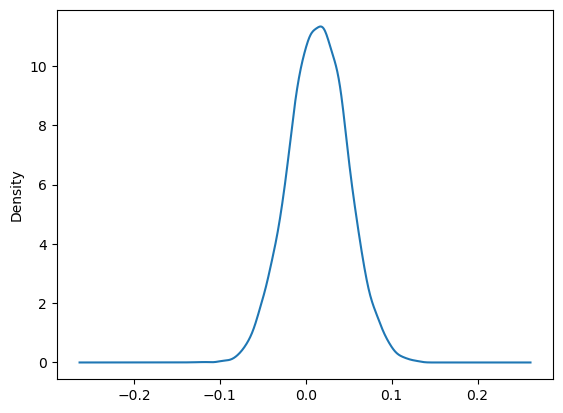

In [8]:
differences = []

for s in range(10000):
    invasiveSample = invasive['Event'].sample(frac=1.0, replace=True)
    conservativeSample = conservative['Event'].sample(frac=1.0, replace=True)
    
    diff = stat(invasiveSample) - stat(conservativeSample)
    differences.append(diff)

differences = pd.Series(differences)

differences.plot.kde()

<Axes: ylabel='Proportion'>

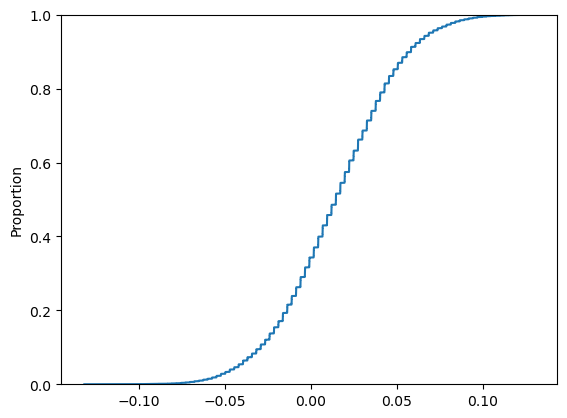

In [9]:
sns.ecdfplot(differences)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?